# Data wrangling‬ for 311 Service requests

## Objective:

   Data wrangling and visualization tasks will be performed to ensure that raw data is transformed into a‬ clean format and then visualized effectively to develop valuable insights. Data wrangling‬ involves handling null values by imputing mean or median values in missing values of columns longitude‬ or latitude‬. Duplicate records are identified and removed, standardizing data types to‬ ensure consistency, such as converting Floating Timestamp to datetime for the date columns‬. Data transformations like encoding categorical variables (e.g., encoding status description “open”=> 0 and “closed” => 1) and normalizing numerical data for easier analysis. Feature engineering to derive‬ new columns, such as calculating response time (e.g., the difference between closed date and‬ requested date will be the response time), and additionally, grouping and mapping subdivisions into‬ broader categories, such as combining detailed service name into high-level service groups for providing‬ clearer insights‬. When unusual values are found in numerical columns, these are outliers,‬ which can be treated by capping or removal to prevent skewed results‬.
    

In [1469]:
#!pip install geopandas


In [1470]:
import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

import numpy as np
import re
import pandas as pd
from tabulate import tabulate
import geopandas as gpd

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

import plotly.express as px

from datetime import datetime
import pytz

In [ ]:
# Load data set for 311 requests 
df = pd.read_csv('/Users/anithajoseph/Documents/UofC/DATA601/CSVFiles/311_Service_Requests_2yrs.csv')
#Load dataset for Community Sectors
community_data=pd.read_csv("/Users/anithajoseph/Documents/UofC/DATA601/601Project/311ServiceRequests/CSV_SECTORS.csv")


### Part 1: Data Cleaning and Preprocessing

### 1.1 Load and Inspect the Dataset

• Load data: Load the dataset and display its shape, column names, and data types.

• Inspect data: Identify and list the number of missing values in each column.

### 1.2 Handling Missing and Unwanted Data

• Handling Missing Data: Drop columns with more than 10% missing values.

• Handling Unwanted Data: Drop requestes created before Jan-1-2023 and after Dec-31-2024.

• Handling Missing Community Code: Fill Community Code with Community name.

• Handling Missing Longitude: Fill Longitude with Median value.

• Handling Missing Latitude: Fill Latitude with median value.

• Handling Missing Point with it's mode value

• Replace values in 'source' column with corresponding service source

### 1.3 Date and Time Handling:

•	Convert the Date column to a datetime object.

•	Create new columns for the year, month, and day of the week for requested, updated and closed date columns.

•	Replacing null values in derived date related columns with 0 and converting the column values to int type.

### 1.4 Create additional columns:

•	Add a column indicating whether each date falls on a weekend.

•	Add a column for time duration to calculate the time took to close the request.

•	Add a column to see if the request is duplicate or not(Yes means duplicate and No means not a duplicate request).

•	Add a column for Season Categorisation of Requests

•	Add a column for Divisions of Agency assigned for the requests

### 1.5 Handling Missing for Community related columns

•	Fill value "Community Centrepoint" for null community code, name and sector.


In [1472]:
print("----------------------------------------------------------------------------")
print("\033[1m"+"Data Analysis and Visualization of Building Emergency Benchmarking"+"\033[0m")
print("----------------------------------------------------------------------------")

#display shape, columns, and data types
print("1.\tShape of the Dataset:", df.shape)
print("2.\tNumber of records or rows of the DataFrame:", df.shape[0])
print("3.\tColumns and Data types of each column:\n", df.dtypes)

----------------------------------------------------------------------------
Data Analysis and Visualization of Building Emergency Benchmarking
----------------------------------------------------------------------------
1.	Shape of the Dataset: (1093918, 15)
2.	Number of records or rows of the DataFrame: 1093918
3.	Columns and Data types of each column:
 service_request_id     object
requested_date         object
updated_date           object
closed_date            object
status_description     object
source                 object
service_name           object
agency_responsible     object
address               float64
comm_code              object
comm_name              object
location_type          object
longitude             float64
latitude              float64
point                  object
dtype: object


In [1473]:
# Inspect data
missingDataSum = df.isna().sum()
missingDataPercentage = (df.isnull().mean() * 100).round(2)
missingData = pd.DataFrame({
    "Missing Count": missingDataSum,
    "Missing Percentage": missingDataPercentage
})

pd.options.display.float_format = '{:.2f}'.format
print("\n\033[1m"+"Missing Count per column:"+"\033[0m")
print(tabulate(missingData, headers='keys', tablefmt='fancy_grid'))

#The dataframe(DF) is copied to another DF variable if in case there is a need for original DF
originalDF =df


Missing Count per column:
╒════════════════════╤═════════════════╤══════════════════════╕
│                    │   Missing Count │   Missing Percentage │
╞════════════════════╪═════════════════╪══════════════════════╡
│ service_request_id │     0           │                 0    │
├────────────────────┼─────────────────┼──────────────────────┤
│ requested_date     │     0           │                 0    │
├────────────────────┼─────────────────┼──────────────────────┤
│ updated_date       │     0           │                 0    │
├────────────────────┼─────────────────┼──────────────────────┤
│ closed_date        │ 39714           │                 3.63 │
├────────────────────┼─────────────────┼──────────────────────┤
│ status_description │     0           │                 0    │
├────────────────────┼─────────────────┼──────────────────────┤
│ source             │     0           │                 0    │
├────────────────────┼─────────────────┼──────────────────────┤
│ service_nam

In [1474]:
# Handling Missing Data
columnNameDropped = missingDataPercentage[missingDataPercentage >= 40].index.tolist()
print("\nColumns with missing percentage more than 40% missing values are:", columnNameDropped)
df = df.drop(columns = missingDataPercentage[missingDataPercentage > 40].index)

# Handling Unwanted Data
beforeCount = df.shape[0]
df = df[(df['requested_date'] < '2025-01-01') & (df['requested_date'] > '2023-01-01')]
afterCount =df.shape[0]
deletedCount = beforeCount - afterCount
print(f"\nCount of deleted request which are recieved on or after 2025-01-01 and before 2023-01-01: {deletedCount}")

#Handling Missing Community Code
communityNames = df[df['comm_code'].isnull() & df['comm_name'].notnull()]['comm_name'].to_list()
print(f"\nCommunity name with community code null and community name exists: {communityNames}")

df['comm_code'].fillna(df['comm_name'])
print(f"\nCommunity Code is filled with Community name for {communityNames} community")

#Handling Missing Longitude and Latitude with their median 
df['longitude'] = df['longitude'].fillna(df['longitude'].median())
df['latitude'] = df['latitude'].fillna(df['latitude'].median())
print("\nLongitude and latitude missing values are replaced with its corresponding median")

#Handling Missing Point with the mode
df['point'] = df['point'].fillna(df['point'].mode()[0])
print("\nPoint missing values are replaced with its mode")

# Replace values in 'source' column with corresponding service source
df['source'] = df['source'].replace('Web', 'Web (Online Form)')
df['source'] = df['source'].replace('App', 'Mobile App')
df['source'] = df['source'].replace('Other','Email & Social Media')


Columns with missing percentage more than 40% missing values are: ['address']

Count of deleted request which are recieved on or after 2025-01-01 and before 2023-01-01: 31076

Community name with community code null and community name exists: ['05E']

Community Code is filled with Community name for ['05E'] community

Longitude and latitude missing values are replaced with its corresponding median

Point missing values are replaced with its mode


In [1475]:
# Date and Time Handling:
#------------------------------------------------------------------------------------------

#Convert the Date column to a datetime object
df['requested_date'] = pd.to_datetime(df['requested_date'], format = '%Y/%m/%d %I:%M:%S %p')
df['updated_date'] = pd.to_datetime(df['updated_date'], format = '%Y/%m/%d %I:%M:%S %p')
df['closed_date'] = pd.to_datetime(df['closed_date'], format = '%Y/%m/%d %I:%M:%S %p')

print("\n\033[1m"+"Date and Time Handling: Modified data type:"+"\033[0m")
print(f"Data type of 'requested_date': {df['requested_date'].dtype}")
print(f"Data type of 'updated_date': {df['updated_date'].dtype}")
print(f"Data type of 'closed_date': {df['closed_date'].dtype}")

# Converting null values to NaT
df['closed_date'] = df['closed_date'].fillna(pd.NaT)

#Create new columns for the year, month, and day of the week for requested, updated and closed date columns
df['request_year'] = df['requested_date'].dt.year
df['request_month'] = df['requested_date'].dt.month
df['request_day'] = df['requested_date'].dt.day
df['update_year'] = df['updated_date'].dt.year
df['update_month'] = df['updated_date'].dt.month
df['update_day'] = df['updated_date'].dt.day
df['closed_year'] = df['closed_date'].dt.year
df['closed_month'] = df['closed_date'].dt.month
df['closed_day'] = df['closed_date'].dt.day

# Map the numerical days to their names for better readability
day_name_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['day_name'] = df['request_day'].map(day_name_map)

# Replacing null values in derived date related columns with 0 and converting the column values to int type
df.loc[df['closed_date'].isna(), ['closed_year', 'closed_month', 'closed_day']] = 0
df[['request_year', 'request_month', 'request_day']] = df[['request_year', 'request_month', 'request_day']].astype('Int32')
df[['update_year', 'update_month', 'update_day']] = df[['update_year', 'update_month', 'update_day']].astype('Int32')
df[['closed_year', 'closed_month', 'closed_day']] = df[['closed_year', 'closed_month', 'closed_day']].astype('Int32')


print("\n\033[1m"+"Date and Time Handling: newly created columns are:"+"\033[0m")
print("For requested_date: request_year, request_month, request_day")
print("For updated_date: update_year, update_month, update_day")
print("For closed_date: closed_year, closed_month, closed_day")


Date and Time Handling: Modified data type:
Data type of 'requested_date': datetime64[ns]
Data type of 'updated_date': datetime64[ns]
Data type of 'closed_date': datetime64[ns]

Date and Time Handling: newly created columns are:
For requested_date: request_year, request_month, request_day
For updated_date: update_year, update_month, update_day
For closed_date: closed_year, closed_month, closed_day


In [1476]:
# Create additional columns:
#-------------------------------------------------------------------------

#Add a column indicating whether each request date falls on a weekend
df['is_weekend_request'] = df['request_day']>= 5

#Add a column for time duration to calculate the time took to close the request
df['response_time'] = df['closed_date'] - df['requested_date']
df['response_time'] = df['response_time'].dt.days

#Add a column to see if the request is duplicate or not(Yes means duplicate and No means not a duplicate request)
df['duplicate_request'] = df['status_description'].str.contains(r'Duplicate \(Closed\)', regex=True)
df['duplicate_request'] = df['duplicate_request'].replace({True: 'Yes', False: 'No'})

print("\n\033[1m"+"Additional Columns created are:"+"\033[0m")
print("\tis_weekend_request")
print("\tresponse_time")
print("\tduplicate_request")


Additional Columns created are:
	is_weekend_request
	response_time
	duplicate_request


In [1477]:
# Season Categorisation of "Requests"
# Defining Calgary's timezone
calgary_tz = pytz.timezone('America/Edmonton')  
# Exact UTC times for solstices and equinoxes (taken from Govt of Canada Website)
seasons_utc = {
    'Spring_2023': '2023-03-20 21:24:00',
    'Summer_2023': '2023-06-21 14:57:00',
    'Autumn_2023': '2023-09-23 06:50:00',
    'Winter_2023': '2023-12-22 03:27:00',
    'Spring_2024': '2024-03-20 03:06:00',
    'Summer_2024': '2024-06-20 20:50:00',
    'Autumn_2024': '2024-09-22 12:43:00',
    'Winter_2024': '2024-12-21 09:20:00'
}

# Converting the UTC times to Calgary local time
seasons = {}
for season, utc_time_str in seasons_utc.items():
    # Converting the UTC string into a datetime object   
    utc_time = datetime.strptime(utc_time_str, '%Y-%m-%d %H:%M:%S')
    utc_time = pytz.utc.localize(utc_time) 
    # Converting to Calgary local time
    local_time = utc_time.astimezone(calgary_tz)
    # Saving the result in the dictionary
    seasons[season] = local_time
#for key, value in seasons.items():
#print(f"{key}: {value.strftime('%Y-%m-%d %H:%M:%S')}")
#    print(f"{key}: {value}")

# Keeping the local time but making it aware for requested_date columns
if df['requested_date'].dt.tz is None:
    df['new_requested_date'] = df['requested_date'].dt.tz_localize('America/Edmonton')
#print(df['new_requested_date'].head())

# Categorizing into seasons and creating a new 'season' column
# Assigning seasons based on request date
def get_season(request_date):
    for season, season_date in seasons.items():
        if request_date < season_date:
            return season
    return 'Winter_2024'  # Default to the latest season

# Creating new season column 
df['Season'] = df['new_requested_date'].apply(get_season)

# Define the date range
start_date = '2023-12-22'
end_date = '2023-12-31'
# Update the Season column for the specified date range
df.loc[(df['requested_date'] >= start_date) & (df['requested_date'] <= end_date), 'Season'] = 'Winter_2023'
#display(df)

print("\n\033[1m"+"Additional Columns created are:"+"\033[0m")
print("\tnew_requested_date")


Additional Columns created are:
	new_requested_date


In [1478]:
#Add column for Community Sector using the community sector csv file
def merge_community_sector(main_data, community_data):
    # Rename the relevant columns in the community_data for clarity and consistency
    community_data.rename(columns={'COMM_CODE': 'comm_code', 'SECTOR': 'community_sector'}, inplace=True)

    # Merge the datasets based on the 'comm_code'
    merged_data = main_data.merge(community_data[['comm_code', 'community_sector']], on='comm_code', how='left')

    return merged_data

df = merge_community_sector(df, community_data)
print("\n\033[1m"+"Additional Columns created are:"+"\033[0m")
print("\tcommunity_sector")

#Handling Missing for Community related columns
df.loc[df['comm_code'].isnull(), 'comm_code'] = "Community Centrepoint"
df.loc[df['comm_name'].isnull(), 'comm_name'] = "Community Centrepoint"
df.loc[df['community_sector'].isnull(), 'community_sector'] = "Community Centrepoint"

# Extract year and month from the requested_date column
df['year_month'] = df['requested_date'].dt.to_period('M')


Additional Columns created are:
	community_sector


In [1479]:
# Add a column for Divisions of Agency assigned for the requests

#Unassigned agencies are assigned to corresponding divisions
df.loc[df['agency_responsible'].isnull() & df['service_name'].str.contains('WATR -'), 'agency_responsible'] = 'UEP - Utilities & Environmental Protection'
df.loc[df['agency_responsible'].isnull() & df['service_name'].str.contains('PSD -'), 'agency_responsible'] = 'PDS - Planning & Development Services'
df.loc[df['agency_responsible'].isnull() & df['service_name'].str.contains('CPI -'), 'agency_responsible'] = 'OSC - Operational Services and Compliance'

# agency abbreviations are extracted
def extract_division(value):
    if pd.isna(value):
        return np.nan
    parts = value.split('-')
    resultStr = parts[0].strip() if '-' in value else value.strip()
    return resultStr


df['agency_division'] = df['agency_responsible'].apply(extract_division)

#Actual agencies or divisions under Calgary Government
agency_division = {
    'agency_name': ['Affiliated Organizations', 'Chief Financial Officer Department', 'Corporate Wide Service Requests',
                    'Calgary Police & Fire Services', 'Community Services', "Deputy City Manager's Office",
                   'Elected Officials', 'Fleet and Inventory', 'Information Services','Legal or Legislative Services',
                   'Office of the City Auditor','Operational Services and Compliance', 'Partnerships',
                   'Planning & Development Services','Project Information and Control Systems', 'Recreation and Social Programs',
                    'Transportation', 'Utilities & Environmental Protection'],
    'abbreviations': [['AO', 'Affiliated Organizations'], ['CFOD'], ['Corporate Wide Service Requests'], 
                      ['CPFS'],['CS'], ['DCMO'], 
                      ['Elected Officials'], ['Fleet and Inventory'], ['IS'], ['LL','LLSS'],
                      ['Office of the City Auditor'],['OS','OSC'],['Partnerships'],
                      ['PD','PDS'],['PICS'],['Recreation and Social Programs'],
                      ['TRAN','Tranc'], ['UEP','Uepc']]
}


# Create a mapping dictionary
mapping = {abbreviation: agency_name 
           for agency_name, abbreviations in zip(agency_division['agency_name'], agency_division['abbreviations']) 
           for abbreviation in abbreviations}


# Replace the agency_division values with actual agency_name or divisions
df['agency_division'] = df['agency_division'].map(mapping)
#noDivisionDF = df[df['agency_division'].isnull()]
#display(noDivisionDF)
agencies= df['agency_division'].unique()
    
# Iterate through each agency division in the list
for division in agencies:
    subset_df = df[df['agency_division'] == division]
    
    # Split the 'agency_responsible' column at the first hyphen and create 'agency_subdivision'
    df.loc[df['agency_division'] == division, 'agency_subdivision'] = subset_df['agency_responsible'].apply(
        lambda x: x.split('-', 1)[1] if '-' in x else division
    )

    # Split the 'service_name' column at the first hyphen and create 'service_category'
    df.loc[df['agency_division'] == division, 'service_category'] = subset_df['service_name'].apply(
        lambda x: x.split('-', 1)[0] if '-' in x else x
    )

    # Split the 'service_name' column at the first hyphen and create 'service_request'
    df.loc[df['agency_division'] == division, 'service_request'] = subset_df['service_name'].apply(
        lambda x: x.split('-', 1)[1] if '-' in x else x
    )
    
#Update Service Category names
df.loc[df['service_category'] == 'CT', 'service_category'] = 'Calgary Transit'
df.loc[df['service_category'] == 'DBBS Inspection', 'service_category'] = 'Development, Business and Building Services'
df.loc[df['service_category'] == 'WRS', 'service_category'] = 'Waste and Recycling Services'
df.loc[df['service_category'] == 'WATS', 'service_category'] = 'Water Services'
df.loc[df['service_category'] == 'Corporate', 'service_category'] = 'Corporate Wide Service Requests'


print("\n\033[1m"+"Additional Columns created are:"+"\033[0m")
print("\tagency_division")
print("\tagency_subdivision")
print("\tservice_category")
print("\tservice_request")



Additional Columns created are:
	agency_division
	agency_subdivision
	service_category
	service_request


In [1480]:
#Filter the records from your dataframe df where closed_date is greater than or equal to requested_date, 
#closed_date is not null, and duplicate_request is 'No'
print("\n\033[1m"+"Agency division and the count of requests handles by each division:"+"\033[0m")
efficiencyDF = df[(df['closed_date'] >= df['requested_date']) & 
                 (df['closed_date'].notna()) & 
                 (df['duplicate_request'] == 'No')]
print(f"For answering the response efficiency, we have considered {efficiencyDF.shape[0]} requests")

average_response_time = round(efficiencyDF['response_time'].mean(), 2)
print(f"Average response time: {average_response_time} days")



Agency division and the count of requests handles by each division:
For answering the response efficiency, we have considered 1021777 requests
Average response time: 12.6 days


### Part 2: Information of New Processed Data Set for 311 requests

• Shape of the new Processed Dataset.

• Count of 311 service requests.

• Columns and Data types of each column.

• 311 Request 'Status' available.

• Agencies resposible for handling service requests.

• Count of all distinct service requests.

• Count of all distinct service requests for all agencies.

In [1482]:
print("1.\tShape of the new Processed Dataset:", df.shape)
print("2.\tCount of 311 service requests:", df.shape[0])
print("3.\tColumns and Data types of each column:")

# Get the columns that are in df but not in originalDF
newColumns = list(set(df.columns) - set(originalDF.columns))
dtypes = df[newColumns].dtypes
width = max(len(column) for column in df.columns) + 2
for column, dtype in dtypes.items():
    print(f"\t\t{column.ljust(width)}{dtype}")
print(f"4.\t311 Request Status available: {df['status_description'].unique()}")
#display(df['status_description'].unique())

status_counts = df['status_description'].value_counts()
dupClosedReqCnt = status_counts['Duplicate (Closed)']
dupOpenReqCnt = status_counts['Duplicate (Open)']
closedReqCnt = status_counts['Closed']
openReqCnt = status_counts['Open']
print(f"\ti.\tCount of Open requests: {openReqCnt}")

# Filter requests where status_description is "open" but has closed date
openButClosedDF = df[(df['status_description'] == 'Open') & (df['closed_date'].notnull())]
openReqWithClosedDateCnt = openButClosedDF['status_description'].value_counts()
print(f"\t\ta.\tCount of Open requests with closed date: {openReqWithClosedDateCnt['Open']}")
openDF = df[(df['status_description'] == 'Open') & (df['closed_date'].isnull())]
openDF = openDF['status_description'].value_counts()
print(f"\t\tb.\tCount of Open requests with no closed date: {openDF['Open']}")

print(f"\tii.\tCount of Closed requests: {closedReqCnt}")
print(f"\tiii.\tCount of Duplicate (Open) requests: {dupOpenReqCnt}")
print(f"\tiv.\tCount of Duplicate (Closed) requests: {dupClosedReqCnt}")

# Inspect data
missingDataSum = df.isna().sum()
missingDataPercentage = (df.isnull().mean() * 100).round(2)
missingData = pd.DataFrame({
    "Missing Count": missingDataSum,
    "Missing Percentage": missingDataPercentage
})

pd.options.display.float_format = '{:.2f}'.format
print("\n\033[1m"+"Missing Count per column:"+"\033[0m")
print(tabulate(missingData, headers='keys', tablefmt='fancy_grid'))


1.	Shape of the new Processed Dataset: (1062919, 35)
2.	Count of 311 service requests: 1062919
3.	Columns and Data types of each column:
		agency_division     object
		Season              object
		request_day         Int32
		duplicate_request   object
		year_month          period[M]
		is_weekend_request  boolean
		closed_day          Int32
		community_sector    object
		response_time       float64
		request_year        Int32
		service_request     object
		update_day          Int32
		update_year         Int32
		request_month       Int32
		day_name            object
		closed_year         Int32
		closed_month        Int32
		new_requested_date  datetime64[ns, America/Edmonton]
		service_category    object
		agency_subdivision  object
		update_month        Int32
4.	311 Request Status available: ['Closed' 'Open' 'Duplicate (Closed)' 'Duplicate (Open)']
	i.	Count of Open requests: 32782
		a.	Count of Open requests with closed date: 2024
		b.	Count of Open requests with no closed date: 30758
	

In [1483]:
# Entire Unique service names
unique_service_name_df = df['service_name'].unique()
print("\n5.\tCount of all distinct service requests:",len(unique_service_name_df))

agency_vise_distinct_req = df[['agency_division','agency_subdivision', 'agency_responsible','service_name']].drop_duplicates()
print("\n6.\tCount of all distinct service requests for all agencies:",len(agency_vise_distinct_req))

#agencies= df['agency_division'].unique()
print("\n7.\tAgencies resposible for handling service requests are:")
for agency in agencies:
    print(f"\t\t- {agency}")


5.	Count of all distinct service requests: 638

6.	Count of all distinct service requests for all agencies: 1037

7.	Agencies resposible for handling service requests are:
		- Chief Financial Officer Department
		- Community Services
		- Operational Services and Compliance
		- Transportation
		- Utilities & Environmental Protection
		- Planning & Development Services
		- Calgary Police & Fire Services
		- Corporate Wide Service Requests
		- Project Information and Control Systems
		- Partnerships
		- Deputy City Manager's Office
		- Legal or Legislative Services
		- Recreation and Social Programs
		- Elected Officials
		- Information Services
		- Affiliated Organizations
		- Fleet and Inventory
		- Office of the City Auditor


# Answer guiding questions

## Analysis

1. Request Source Analysis
2. Request Volume and Trends Analysis
3. Request Status Analysis
4. Weekend vs. Weekday analysis
5. Service Category Analysis
6. Agency Performance
7. Duplicate Request Analysis



### 1. Request Source Analysis

Unique 311 request sources are:


,count
source,
Email & Social Media,588086
Phone,236463
Mobile App,196755
Web (Online Form),473


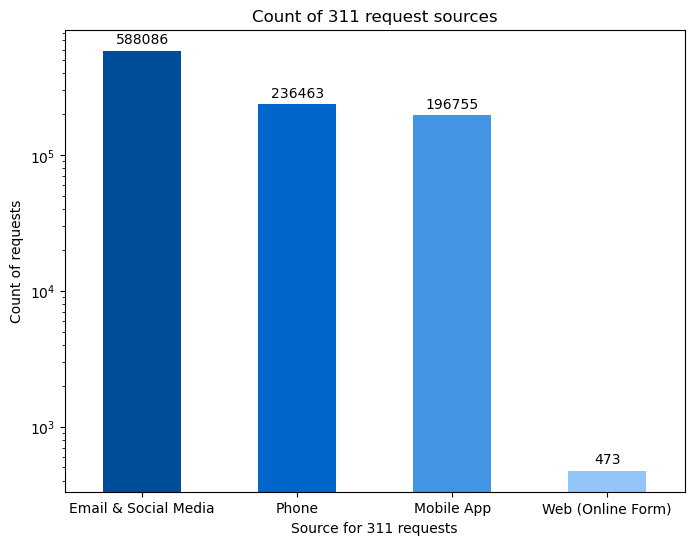

In [1486]:
# Get the count of each unique value in the 'source' column
source_counts = pd.DataFrame(efficiencyDF['source'].value_counts())
print("Unique 311 request sources are:")
display(source_counts)

# Create a bar chart with a logarithmic scale
plt.figure(figsize=(8, 6))
ax = source_counts['count'].plot(kind='bar', color=['#004D99', '#0066CC', '#4394E5', '#92C5F9'])
plt.xlabel('Source for 311 requests')
plt.ylabel('Count of requests')
plt.title('Count of 311 request sources')
plt.yscale('log')
plt.xticks(rotation=0)
# Add count values on top of the bars
for i in ax.patches:
    ax.annotate(str(i.get_height()), (i.get_x() + i.get_width() / 2, i.get_height()), 
                ha='center', va='center', xytext=(0, 8), textcoords='offset points')
plt.show()


### 2. Request Volume and Trends and Seasonal Analysis

• Yearly/Monthly Trends:Analyze the number of service requests over different years and months to identify trends 

#megha
During which seasons do service requests occur most often?
How do service requests change over seasons? Are there any identifiable patterns?


request_year
2023    535281
2024    486496
dtype: int64

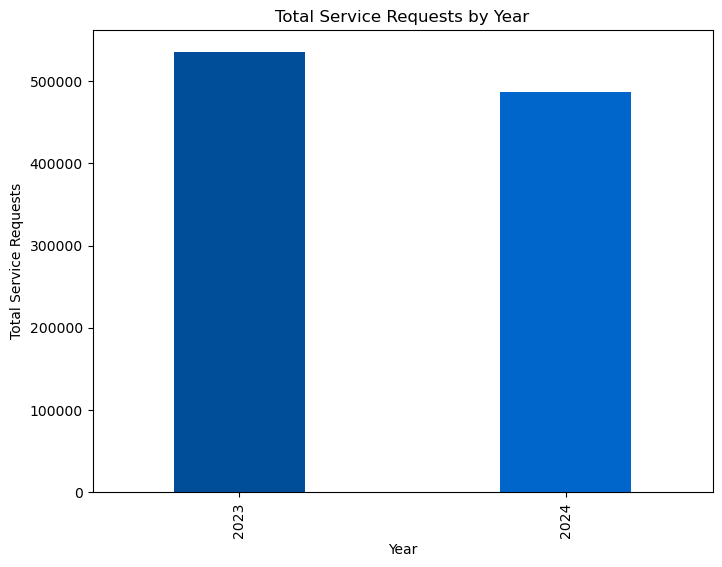

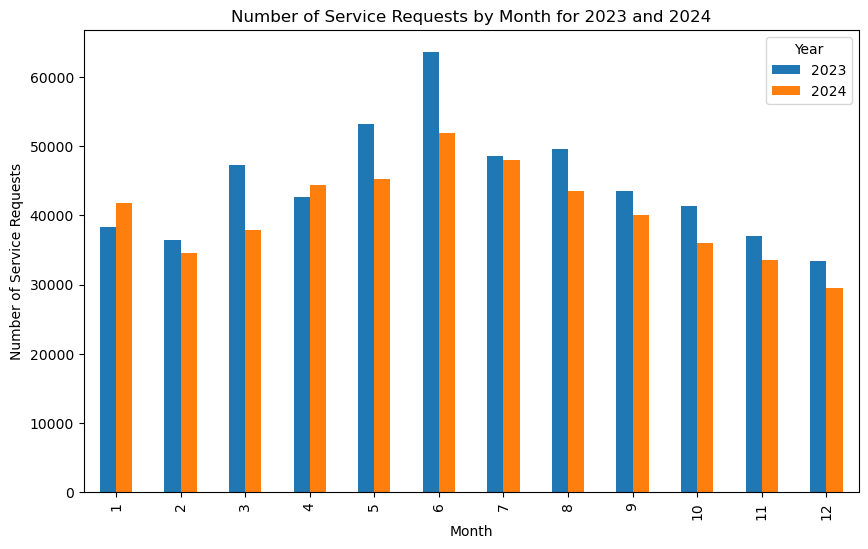

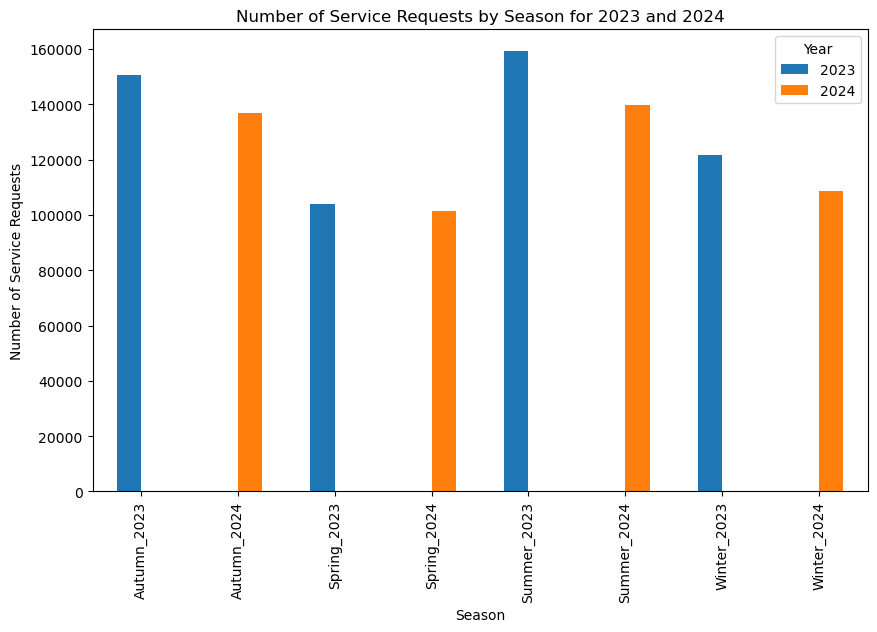

,Season,request_year,service_request_count
0,Autumn_2023,2023,150747
1,Autumn_2024,2024,136768
2,Spring_2023,2023,103924
3,Spring_2024,2024,101249
4,Summer_2023,2023,159079
5,Summer_2024,2024,139805
6,Winter_2023,2023,121531
7,Winter_2024,2024,108674


request_year,2023,2024
request_month,,
1,38333,41816
2,36471,34499
3,47350,37847
4,42674,44429
5,53256,45261
6,63642,51872
7,48610,48070
8,49601,43578
9,43588,40045


In [1488]:
# Aggregate the data by year and month
yearly_data = efficiencyDF.groupby('request_year').size()
display(yearly_data)

# Filter the data for the years 2023 and 2024
efficiency_filtered = efficiencyDF[(efficiencyDF['request_year'] == 2023) | (efficiencyDF['request_year'] == 2024)]
# Group by year and month and count the number of service requests
monthly_trends = efficiency_filtered.groupby(['request_year', 'request_month']).size().reset_index(name='service_request_count')
# Pivot the table to make it easier to plot
monthly_trends_pivot = monthly_trends.pivot(index='request_month', columns='request_year', values='service_request_count')

# Group by season and year and count the number of service requests
seasonal_trends = efficiency_filtered.groupby(['Season', 'request_year']).size().reset_index(name='service_request_count')
# Pivot the table to make it easier to plot
seasonal_trends_pivot = seasonal_trends.pivot(index='Season', columns='request_year', values='service_request_count')


# Plot the number of service requests by year
plt.figure(figsize=(8, 6))
yearly_data.plot(kind='bar', color=['#004D99', '#0066CC'], width = 0.40)
plt.xlabel('Year')
plt.ylabel('Total Service Requests')
plt.title('Total Service Requests by Year')
plt.show()

# Plot the number of service requests by month
monthly_trends_pivot.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Month')
plt.ylabel('Number of Service Requests')
plt.title('Number of Service Requests by Month for 2023 and 2024')
plt.legend(title='Year')
plt.show()


# Plot the number of service request by Season
seasonal_trends_pivot.plot(kind='bar', figsize=(10, 6), width =0.5)
plt.xlabel('Season')
plt.ylabel('Number of Service Requests')
plt.title('Number of Service Requests by Season for 2023 and 2024')
plt.legend(title='Year')
plt.show()

# Display the result
display(seasonal_trends)

# Display the result
display(monthly_trends_pivot)



### 3. Request Status Analysis

• Status Distribution: Examine the distribution of different status descriptions (e.g., Open, Closed) and their evolution over time.
  
• Status Efficiency: Analyze how quickly different statuses are reached from the initial request.

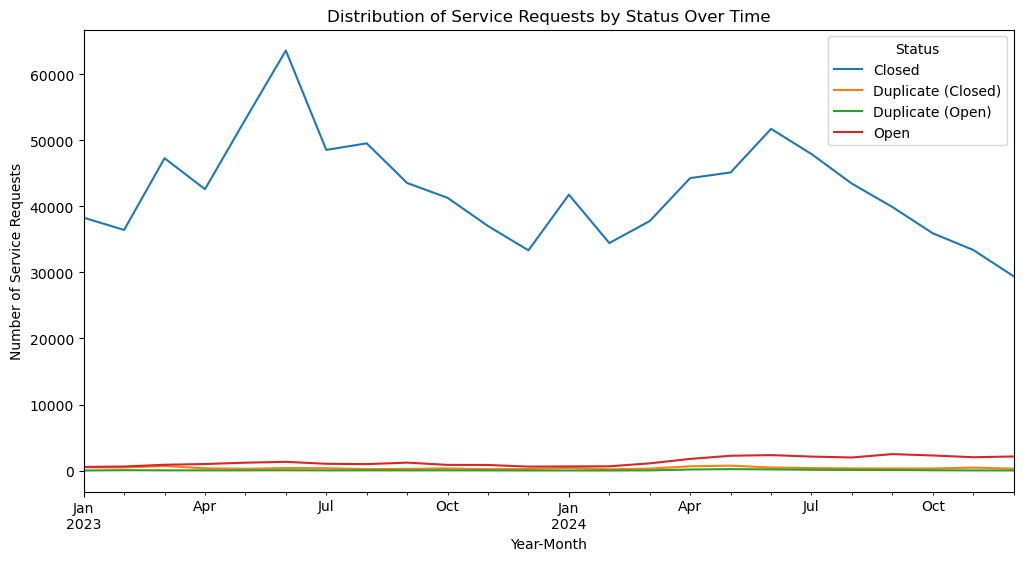

status_description,Closed,Duplicate (Closed),Duplicate (Open),Open
year_month,,,,
2023-01,38285,496,6,552
2023-02,36426,468,58,612
2023-03,47286,687,30,879
2023-04,42601,343,28,990
2023-05,53174,265,30,1195
2023-06,63591,386,45,1319
2023-07,48546,354,26,1026
2023-08,49540,221,32,978
2023-09,43535,254,25,1200


,status_description,time_to_update,time_to_close
0,Closed,27.73,12.59
1,Duplicate (Closed),278.02,15.93
2,Duplicate (Open),88.48,2.00
3,Open,82.48,18.11


In [1490]:
# Convert requested_date to datetime if not already in datetime format
df['requested_date'] = pd.to_datetime(df['requested_date'])

# Extract year and month from the requested_date column
df['year_month'] = df['requested_date'].dt.to_period('M')

# Group by year_month and status_description, then count the number of occurrences
status_trends = df.groupby(['year_month', 'status_description']).size().reset_index(name='status_count')

# Pivot the table to make it easier to plot
status_trends_pivot = status_trends.pivot(index='year_month', columns='status_description', values='status_count').fillna(0)

# Plotting the status distribution over time
status_trends_pivot.plot(kind='line', figsize=(12, 6))
plt.xlabel('Year-Month')
plt.ylabel('Number of Service Requests')
plt.title('Distribution of Service Requests by Status Over Time')
plt.legend(title='Status')
plt.show()

# Display the result
display(status_trends_pivot)


# Calculate time differences in days
df['time_to_update'] = (df['updated_date'] - df['requested_date']).dt.days
df['time_to_close'] = (df['closed_date'] - df['requested_date']).dt.days

# Group by status_description and calculate average time differences
status_efficiency = df.groupby('status_description').agg({
    'time_to_update': 'mean',
    'time_to_close': 'mean'
}).reset_index()

# Display the result
display(status_efficiency)


### 4. Weekend Analysis

• Weekend Requests: Analyze the volume and efficiency of service requests made on weekends versus weekdays.

• Weekend Performance: Compare response times for weekend requests to those made during the week

Weekend Requests Volume: 923102
Weekday Requests Volume: 139817
Average Response Time (Weekend): 12.589854034738101 days
Average Response Time (Weekday): 12.89793013944091 days


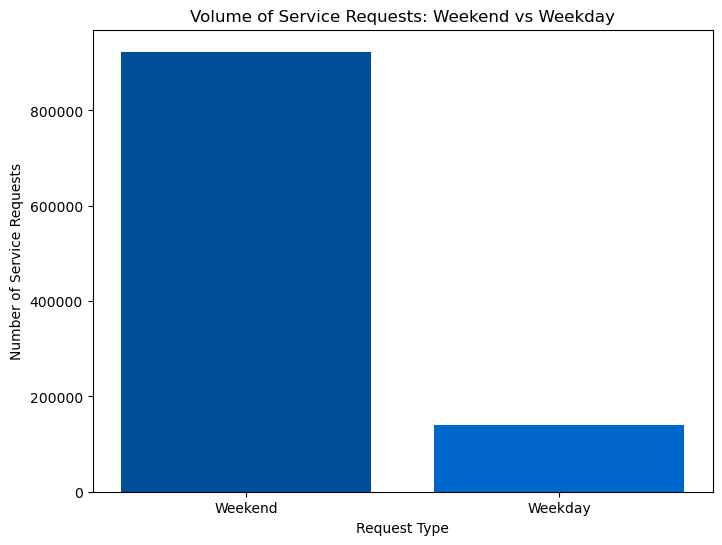

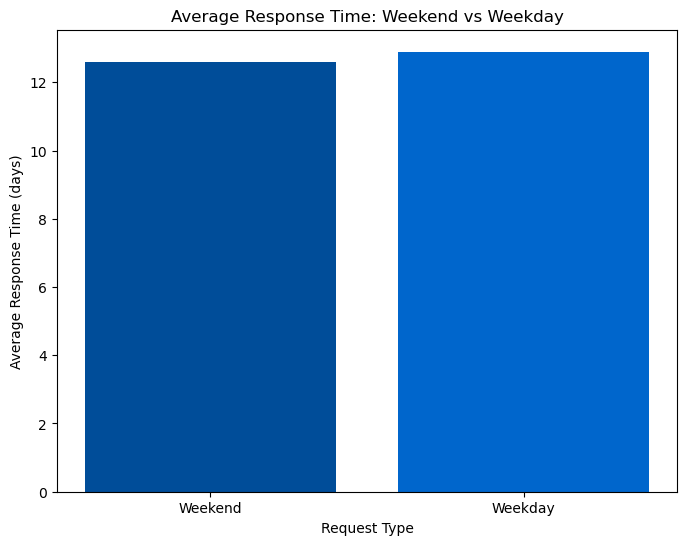

In [1492]:
# Separate weekend and weekday requests
weekend_requests = df[df['is_weekend_request']]
weekday_requests = df[~df['is_weekend_request']]

# Calculate the volume of service requests for weekends and weekdays
weekend_volume = weekend_requests.shape[0]
weekday_volume = weekday_requests.shape[0]

# Calculate the average response time for weekends and weekdays
average_response_time_weekend = weekend_requests['response_time'].mean()
average_response_time_weekday = weekday_requests['response_time'].mean()

# Display the results
print(f'Weekend Requests Volume: {weekend_volume}')
print(f'Weekday Requests Volume: {weekday_volume}')
print(f'Average Response Time (Weekend): {average_response_time_weekend} days')
print(f'Average Response Time (Weekday): {average_response_time_weekday} days')

# Plotting the volume of service requests
volumes = [weekend_volume, weekday_volume]
labels = ['Weekend', 'Weekday']
plt.figure(figsize=(8, 6))
plt.bar(labels, volumes, color=['#004D99', '#0066CC'])
plt.xlabel('Request Type')
plt.ylabel('Number of Service Requests')
plt.title('Volume of Service Requests: Weekend vs Weekday')
plt.show()

# Plotting the average response time
response_times = [average_response_time_weekend, average_response_time_weekday]
plt.figure(figsize=(8, 6))
plt.bar(labels, response_times, color=['#004D99', '#0066CC'])
plt.xlabel('Request Type')
plt.ylabel('Average Response Time (days)')
plt.title('Average Response Time: Weekend vs Weekday')
plt.show()

### 5. Service Category Analysis

• Service Category Popularity: Identify the most common service categories and how they vary over time.

• Efficiency by Category: Compare response times across different service categories to identify potential bottlenecks.

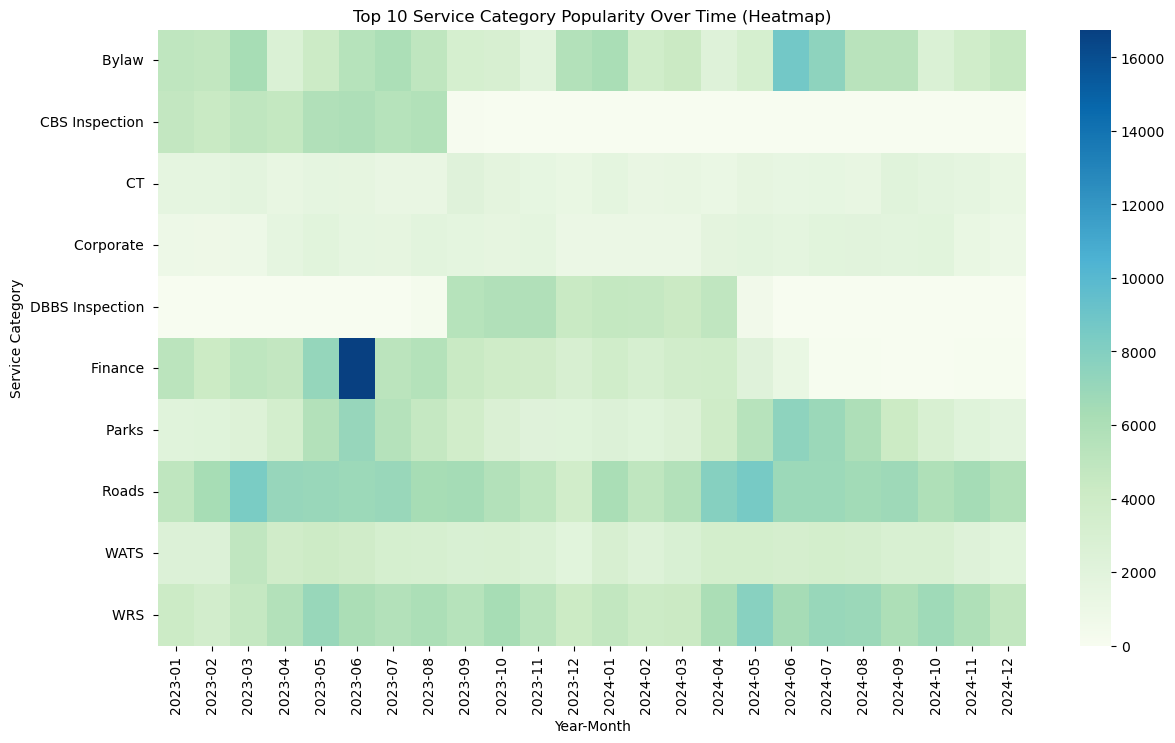

<Figure size 1200x1000 with 0 Axes>

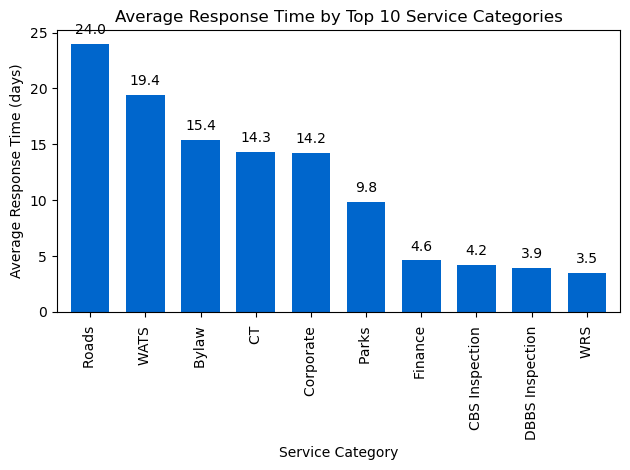

,service_category,response_time
7,Roads,24.00
8,WATS,19.38
0,Bylaw,15.39
2,CT,14.28
3,Corporate,14.19
6,Parks,9.81
5,Finance,4.61
1,CBS Inspection,4.22
4,DBBS Inspection,3.92
9,WRS,3.48


In [1494]:
# Group by year_month and service_category, then count the number of occurrences
service_category_trends = efficiencyDF.groupby(['year_month', 
                                                'service_category']).size().reset_index(name='service_category_count')

# Get the top 10 service categories by total number of requests
top_service_categories = service_category_trends.groupby('service_category')['service_category_count'].sum().nlargest(10).index

# Filter the trends to include only the top 10 service categories
top_service_category_trends = service_category_trends[service_category_trends['service_category'].isin(top_service_categories)]

# Pivot the table to make it easier to plot
top_service_category_trends_pivot = top_service_category_trends.pivot(index='year_month', 
                                                                      columns='service_category', 
                                                                      values='service_category_count').fillna(0)

# Plotting the most common service categories over time as a heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(top_service_category_trends_pivot.T, annot=False, fmt='g', cmap='GnBu')
plt.xlabel('Year-Month')
plt.ylabel('Service Category')
plt.title('Top 10 Service Category Popularity Over Time (Heatmap)')
plt.show()


# Calculate the total number of requests for each service category
total_requests_by_category = efficiencyDF.groupby('service_category').size().reset_index(name='total_requests')

# Get the top 10 service categories by the number of requests
top_service_categories = total_requests_by_category.nlargest(10, 'total_requests')['service_category']

# Filter the DataFrame to include only the top 10 service categories
top_service_category_df = efficiencyDF[efficiencyDF['service_category'].isin(top_service_categories)]

# Calculate average response time for each of the top 10 service categories
response_time_by_category = top_service_category_df.groupby('service_category')['response_time'].mean().reset_index()

# Identify potential bottlenecks by sorting categories with the highest average response time
response_time_by_category = response_time_by_category.sort_values(by='response_time', ascending=False)

print("\n")

# Plotting the average response time for each of the top 10 service categories
plt.figure(figsize=(12, 10))
ax = response_time_by_category.plot(kind='bar', x='service_category', y='response_time', 
                                    legend=False, color='#0066CC', width=0.7)
plt.xlabel('Service Category')
plt.ylabel('Average Response Time (days)')
plt.title('Average Response Time by Top 10 Service Categories')
#plt.xticks(rotation=20)
plt.tight_layout()

# Add the response time on top of each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

plt.show()

# Display the result
display(response_time_by_category)


### 5. Geospatial Analysis
#megha
• Community-wise Distribution: Analyze the distribution of service requests across different communities and sectors.
 
• Location Type Analysis: Determine if certain types of locations (e.g., residential, commercial) have more service requests.
 
• Geographic Hotspots: Use longitude and latitude to identify geographic areas with higher service request volumes.

### 6. Agency Performance
#megha
• Agency Efficiency: Compare the efficiency of different agencies responsible for handling service requests.


#### Response Efficiency

To answer this we have to consider the requests which are not duplicate, and which has closed date>= requested_date

#### Questions?

• Which agency handles the most and least number of service requests?

• What is the average response rate and time for resolving for service requests for each agency?

• Who are the most efficient agencies in terms of response and resolution times?

• How does the response efficiency vary across different years?

• How does the response efficiency vary across different years for each agency divisions?


<Figure size 1400x800 with 0 Axes>

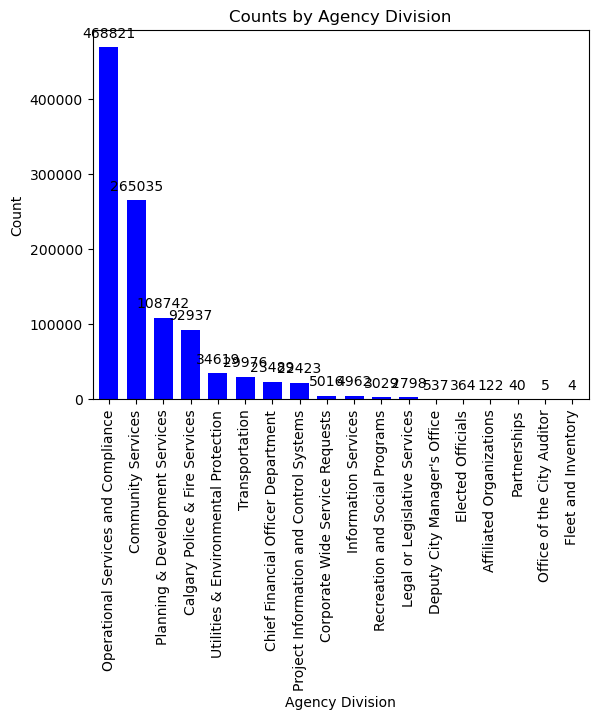

In [1507]:
# Group by 'agency_division' and count the occurrences
grouped_counts = df.groupby('agency_division').size().reset_index(name='count')

# Sort the grouped data by count in descending order
grouped_counts = grouped_counts.sort_values(by='count', ascending=False)

# Plotting the grouped and sorted counts
plt.figure(figsize=(14, 8))
ax = grouped_counts.plot(kind='bar', x='agency_division', y='count', legend=False, color='blue', width=0.7)
plt.xlabel('Agency Division')
plt.ylabel('Count')
plt.title('Counts by Agency Division')
#plt.xticks(rotation=45)
#plt.tight_layout()

# Add the count on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

#plt.show()


In [ ]:

#The most and least request handled agencies
grouped_counts = efficiencyDF.groupby(['agency_division']).size().reset_index(name='count')
sorted_counts = grouped_counts.sort_values(by='count', ascending=False)
first_row = sorted_counts.head(1).to_string(index=False, header=False)
last_row = sorted_counts.tail(1).to_string(index=False, header=False)
print(f"The agency that handled the highest number of service requests and its count: {first_row}")
print(f"The agency that handled the lowest number of service requests and its count: {last_row}")
print("Agency division and the count of requests handles by each division is as given below:")
display(sorted_counts.head(6))

# Group by 'agency_division' and calculate the count of requests and average response time
print("\n\033[1m"+"Agency division, Count of requests and its efficiency:"+"\033[0m")
groupedEfficiencyDF = efficiencyDF.groupby('agency_division').agg(
    request_count=('service_request_id', 'size'),
    average_response_time=('response_time', 'mean')
).reset_index()
groupedEfficiencyDF['average_response_time'] = groupedEfficiencyDF['average_response_time'].round(2)
groupedEfficiencyDF = groupedEfficiencyDF.sort_values(by='average_response_time', ascending=True)
first_row = groupedEfficiencyDF.head(1).to_string(index=False, header=False)
last_row = groupedEfficiencyDF.tail(1).to_string(index=False, header=False)
print(f"The most efficient agency and its response time: {first_row}")
print(f"The least efficient agency and its response time: {last_row}")
print("Agency division, Count of requests and its efficiency in days:")
display(groupedEfficiencyDF)


# How does the response efficiency vary across different years
print("\n\033[1m"+"Response efficiency of Agency division over years:"+"\033[0m")
average_response_time_per_year = efficiencyDF.groupby('request_year').agg(
    request_count=('service_request_id', 'size'),
    average_response_time=('response_time', 'mean')
).reset_index()
average_response_time_per_year['average_response_time'] = average_response_time_per_year['average_response_time'].round(2)
average_response_time_per_year = average_response_time_per_year.sort_values(by='request_year', ascending=True)
print("Average response efficiency per year for all agency divisions:")
display(average_response_time_per_year)


# How the response efficiency vary across different years for each agency divisions
average_response_time_per_year_and_agency = efficiencyDF.groupby(['request_year', 'agency_division']).agg(
    request_count=('service_request_id', 'size'),
    average_response_time=('response_time', 'mean')
).reset_index()
average_response_time_per_year_and_agency['average_response_time'] = average_response_time_per_year_and_agency['average_response_time'].round(2)
average_response_time_per_year_and_agency = average_response_time_per_year_and_agency.sort_values(by=['request_year', 'agency_division'], ascending=True)
#display(average_response_time_per_year_and_agency)


pivoted_df = average_response_time_per_year_and_agency.pivot(index='agency_division', columns='request_year', values=['request_count', 'average_response_time'])
display(pivoted_df)

#average_response_time_per_year_and_agency.unstack(level='request_year')


### 7. Duplicate Request Analysis

• Duplicate Request Identification: Determine the percentage of duplicate requests and the reasons behind them.

• Impact on Efficiency: Assess the impact of duplicate requests on overall response time and resource allocation.

### 7. Time Series Analysis

• Time Series Modeling: Use time series analysis to forecast future service request volumes and identify cyclical patterns.

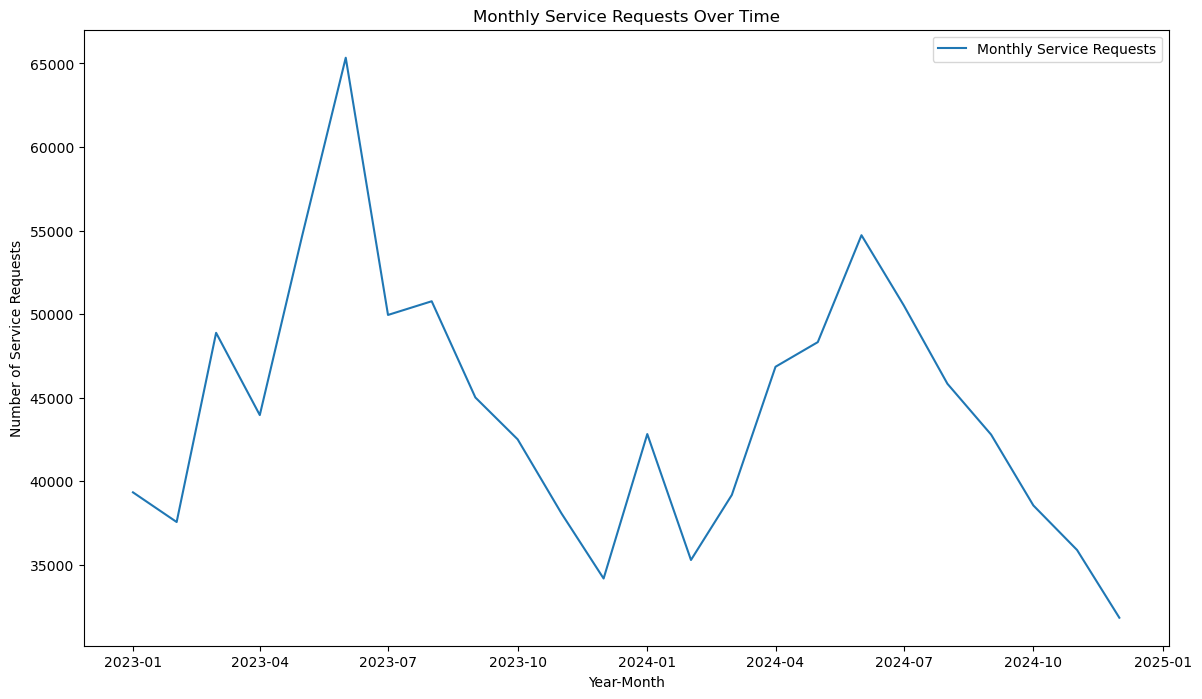

NameError: name 'seasonal_decompose' is not defined

In [1501]:
# Group by year_month and count the number of service requests
monthly_requests = df.groupby('year_month').size()

# Convert to a DataFrame and set the index
monthly_requests = monthly_requests.to_timestamp()

# Visualize the historical data
plt.figure(figsize=(14, 8))
plt.plot(monthly_requests, label='Monthly Service Requests')
plt.xlabel('Year-Month')
plt.ylabel('Number of Service Requests')
plt.title('Monthly Service Requests Over Time')
plt.legend()
plt.show()

# Decompose the time series
decomposition = seasonal_decompose(monthly_requests, model='additive')
fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.show()

# Build and fit ARIMA model
model = ARIMA(monthly_requests, order=(1, 1, 1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Forecast future service request volumes
forecast_steps = 12  # Forecast for the next 12 months
forecast = model_fit.forecast(steps=forecast_steps)

# Visualize the forecast
plt.figure(figsize=(14, 8))
plt.plot(monthly_requests, label='Historical Data')
plt.plot(forecast, label='Forecast', color='red')
plt.xlabel('Year-Month')
plt.ylabel('Number of Service Requests')
plt.title('Service Request Forecast')
plt.legend()
plt.show()

## Trends Over Time 

• How has the volume and type of service requests changed over the years?

• Are there noticeable trends in requests that could be used for future planning?


In [ ]:
display(efficiencyDF.columns)
comm_code_counts = df['service_name'].value_counts().sort_values(ascending=False)
display(comm_code_counts.head(10))

same_division_df = efficiencyDF[efficiencyDF['agency_division'] == efficiencyDF['agency_subdivision']]
display(same_division_df)

same_division_df = efficiencyDF[efficiencyDF['agency_division'] == 'Corporate Wide Service Requests']
display(same_division_df)

file_path = '/Users/anithajoseph/Documents/UofC/DATA601/Project_Proposal/ProposalDocs/service_requests.csv'

comm_code_counts = efficiencyDF['service_category'].value_counts().sort_values(ascending=False)
display(comm_code_counts.head(20))
# Write the DataFrame to a CSV file
#comm_code_counts.to_csv(file_path, index=False)

comm_code_counts = df['agency_subdivision'].value_counts().sort_values(ascending=False)
#display(comm_code_counts)




comm_code_counts = df['service_name'].value_counts().sort_values(ascending=False)
#display(comm_code_counts.head(10))